In [87]:
from class_dataset import ChestDataset
from sklearn.model_selection import train_test_split
import pandas as pd
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras import applications
from keras.applications import DenseNet121
from keras import models
import tensorflow as tf
from glob import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
sns.set_style('whitegrid')

In [27]:
df = pd.read_csv('data_kaggle/Data_Entry_2017.csv')
data_dir = '../image/images/'
dataset = ChestDataset(data_dir,df)
dataset.reset_folder()

In [35]:
dataset = ChestDataset(data_dir,df)
df['path'] = dataset.image_path

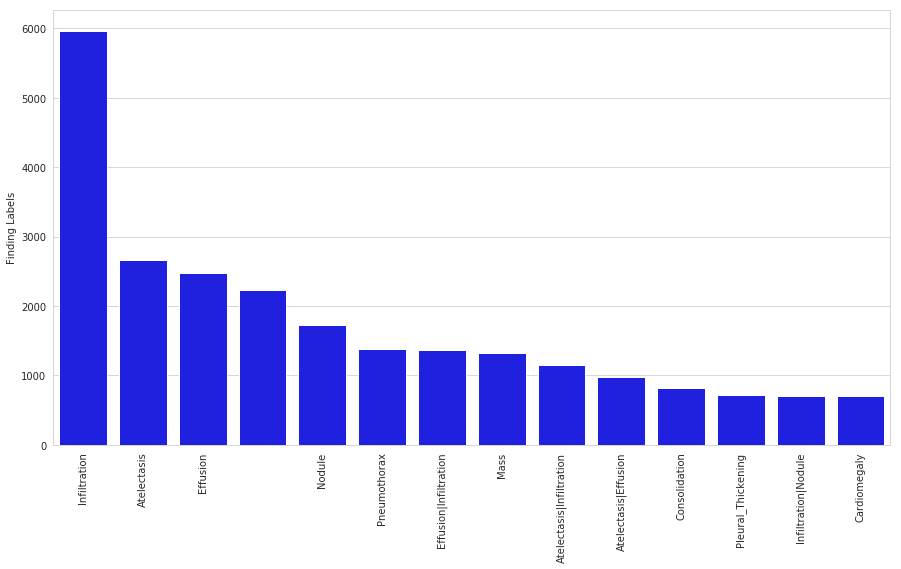

In [62]:
counts = df['Finding Labels'].value_counts()[:14]
plt.figure(figsize=(15,8))
sns.barplot(counts.index,counts,color='blue')
plt.xticks(rotation=90)
plt.show()

In [57]:
df['Finding Labels'] = df['Finding Labels'].replace('No Finding','')
labels = list(df['Finding Labels'][~df['Finding Labels'].str.contains('\|')].unique())

for label in labels:
    if label != '':
        df[label] = df['Finding Labels'].map(lambda x: 1 if label in x else 0)
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Effusion,Atelectasis,Pleural_Thickening,Pneumothorax,Mass,Fibrosis,Consolidation,Edema,Pneumonia
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,1,0,0,0,0,0,0,0,0
3,00000002_000.png,,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,0,0,0,0,0,0,0,0


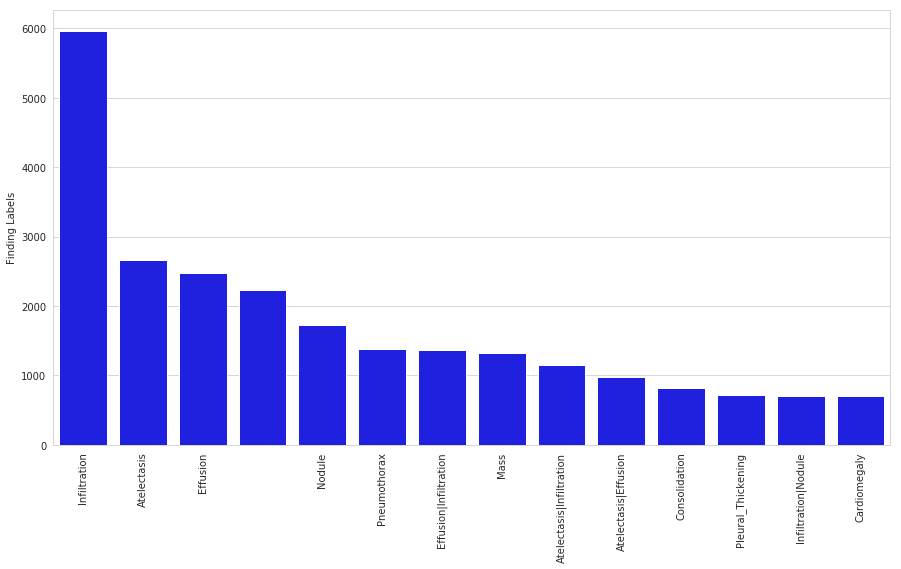

In [61]:
sample_weights = df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
df = df.sample(40000, weights=sample_weights)

counts = df['Finding Labels'].value_counts()[:14]
plt.figure(figsize=(15,8))
sns.barplot(counts.index,counts,color='blue')
plt.xticks(rotation=90)
plt.show()

In [69]:
labels

['Cardiomegaly',
 'Hernia',
 'Infiltration',
 'Nodule',
 'Emphysema',
 'Effusion',
 'Atelectasis',
 'Pleural_Thickening',
 'Pneumothorax',
 'Mass',
 'Fibrosis',
 'Consolidation',
 'Edema',
 'Pneumonia']

In [72]:
label_counts

array([ 5.5325,  0.43  , 37.9375, 12.4125,  5.0225, 27.11  , 23.1475,
        6.9575, 10.4025, 11.485 ,  3.2625,  9.595 ,  4.72  ,  2.9575])

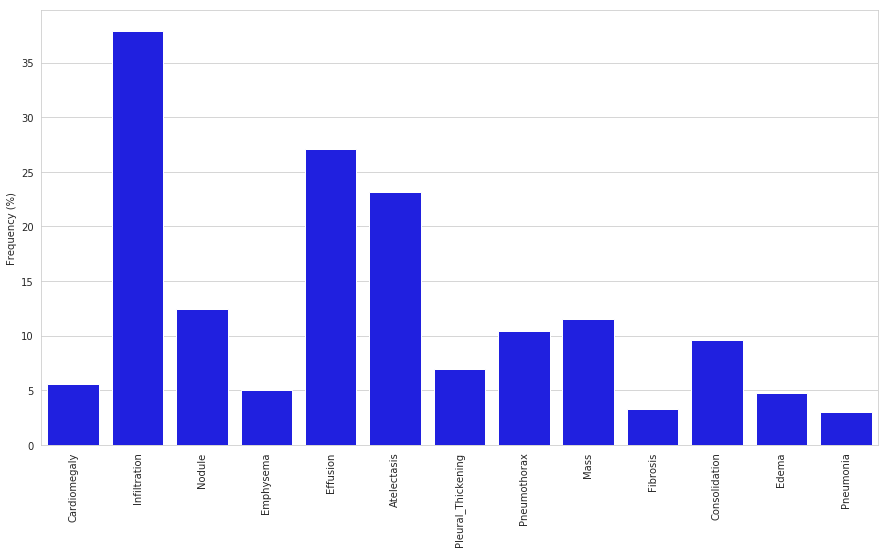

In [76]:
# labels.remove('Hernia')
label_counts = 100*np.mean(df[labels].values,0)

plt.figure(figsize=(15,8))
sns.barplot(labels,label_counts,color='blue')
plt.xticks(rotation=90)
plt.ylabel('Frequency (%)')
plt.show()


In [78]:
df['disease_vec'] = df.apply(lambda x: [x[labels].values], 1).map(lambda x: x[0])
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Atelectasis,Pleural_Thickening,Pneumothorax,Mass,Fibrosis,Consolidation,Edema,Pneumonia,disease_vec
94502,00024264_000.png,Cardiomegaly,0,24264,22,M,PA,2974,2677,0.143,...,0,0,0,0,0,0,0,0,0,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
27959,00007286_009.png,Infiltration|Nodule,9,7286,52,M,AP,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
96105,00025290_005.png,Infiltration,5,25290,45,F,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,0,0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
67228,00016599_001.png,Infiltration|Pneumonia,1,16599,48,F,PA,2446,2991,0.143,...,0,0,0,0,0,0,0,0,1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
87749,00021695_006.png,Effusion|Mass,6,21695,16,F,PA,2658,2991,0.143,...,1,0,0,0,1,0,0,0,0,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]"


In [84]:
train_df, val_df = train_test_split(df,test_size=0.2,random_state=613,stratify=df['Finding Labels'].map(lambda x: x[:4]))

print(train_df.shape[0],val_df.shape[0])

32000 8000


In [86]:
IMG_SIZE = (365, 365)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 32)

val_gen = flow_from_dataframe(core_idg, val_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 256)

test_X, test_Y = next(flow_from_dataframe(core_idg, 
                               val_df, 
                             path_col = 'path',
                            y_col = 'disease_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'grayscale',
                            batch_size = 1024))

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 32000 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 8000 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 8000 images


FileNotFoundError: [Errno 2] No such file or directory: '../image/images/00020043_017.png'

### Divergence 

In [ ]:
densenet = DenseNet121(weights='imagenet', include_top=False,input_shape = IMG_SIZE)

# # Freeze some layers
# for layer in densenet.layers[:]:
#     layer.trainable = False
    
# Create the model
model = models.Sequential()
model.add(densenet)

model.add(Flatten())
# model.add(Dense(72))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.248))
model.add(Dense(15, activation='softmax'))

# Show a summary of the model. Check the number of trainable parameters
model.summary()

In [ ]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])

model.fit_generator(train_gen,steps_per_epoch=100,
                    validation_data = (test_X, test_Y), 
                    epochs = 10)

In [ ]:
pred_Y = model.predict(test_X, batch_size = 32, verbose = True)

fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')